In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import copy
from utils import merge_image_superpixels
from sklearn.neighbors import KDTree

In [2]:
image_names = ["2007_000068", "2007_000121", "2007_000123"]
voc_ext = ".jpg"
gt_ext = ".png"

voc_dir = "data/voc12/"
gt_dir = "data/gt/"

images = []
gt_images = []

images_gray = []

for name in image_names:
    img = cv2.imread(voc_dir + name + voc_ext)
    gt = cv2.imread(gt_dir + name + gt_ext)
   
    images.append(img)
    gt_images.append(gt)

    images_gray.append(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY))

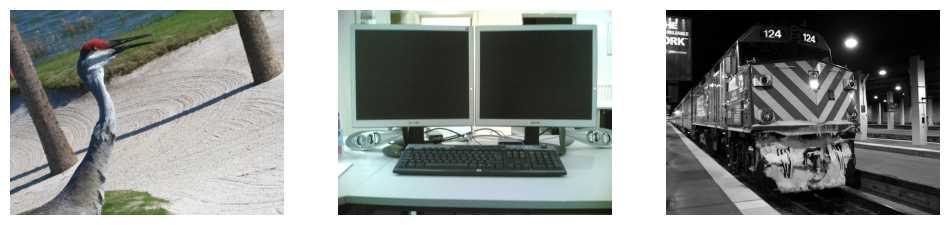

In [3]:
fig = plt.figure(figsize=(12, 4))

rows = 1
cols = 3

for i, img in enumerate(images):
    fig.add_subplot(rows, cols, i+1)
    plt.axis("off")
    plt.imshow(img[:,:,::-1])

## Superpixels

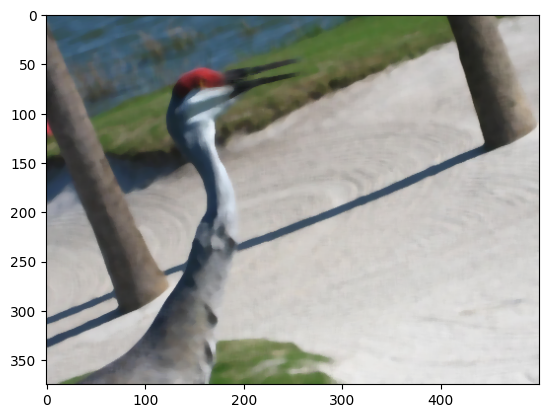

In [4]:
median_blurred = cv2.medianBlur(images[0], 7)
plt.imshow(median_blurred[:,:,::-1])

In [5]:
use_blurred = True
lab_img = cv2.cvtColor(images[0], cv2.COLOR_BGR2Lab)

if use_blurred:
    lab_img = cv2.cvtColor(median_blurred, cv2.COLOR_BGR2Lab)

superpixels_slic = cv2.ximgproc.createSuperpixelSLIC(lab_img, algorithm=cv2.ximgproc.SLIC, region_size=16)
superpixels_slic.iterate(20)
superpixels_slic_mask = superpixels_slic.getLabelContourMask()
print(superpixels_slic.getNumberOfSuperpixels())

height, width, channels = lab_img.shape[0], lab_img.shape[1], lab_img.shape[2]

superpixels_seeds = cv2.ximgproc.createSuperpixelSEEDS(width, height, channels, 1000, 20)
superpixels_seeds.iterate(lab_img, 20)
superpixels_seeds_mask = superpixels_seeds.getLabelContourMask()
print(superpixels_seeds.getNumberOfSuperpixels())

superpixels_lsc = cv2.ximgproc.createSuperpixelLSC(lab_img, region_size=16)
superpixels_lsc.iterate(20)
superpixels_lsc_mask = superpixels_lsc.getLabelContourMask()
print(superpixels_lsc.getNumberOfSuperpixels())

713
713
713


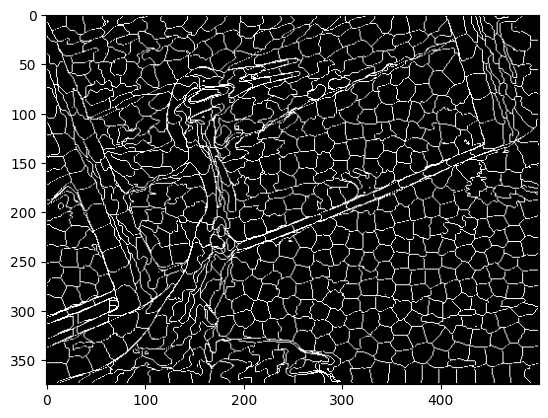

In [6]:
plt.imshow(superpixels_slic_mask, cmap="gray")

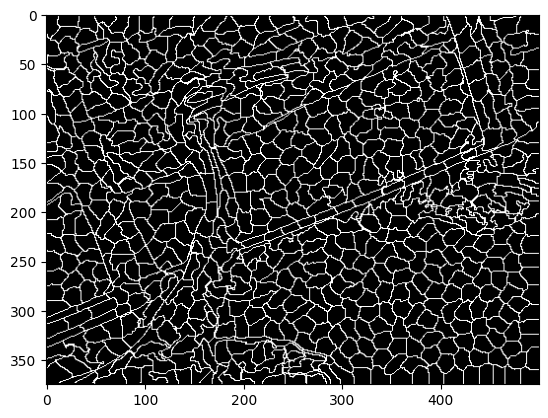

In [7]:
plt.imshow(superpixels_seeds_mask, cmap="gray")

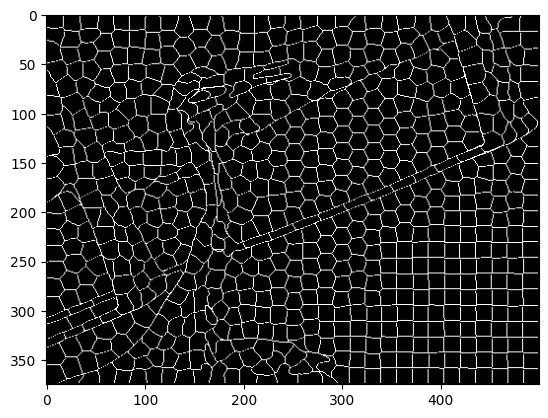

In [8]:
plt.imshow(superpixels_lsc_mask, cmap="gray")

In [9]:
chosen_superpixels = superpixels_lsc
chosen_superpixels_mask = superpixels_lsc_mask

In [10]:
superpixel_contour_img = merge_image_superpixels(images[0], chosen_superpixels_mask, [0,255,0])

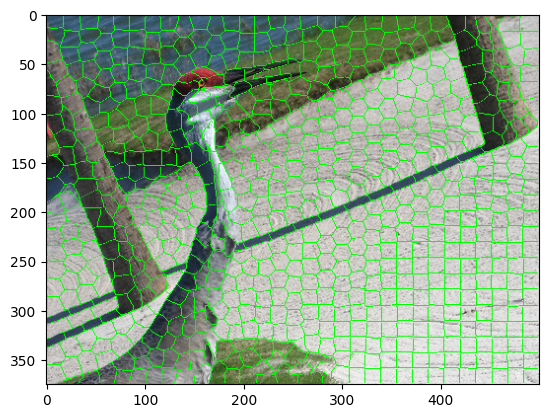

In [11]:
plt.imshow(superpixel_contour_img[:,:,::-1])

In [12]:
superpixel_labels = chosen_superpixels.getLabels()
mean_img = np.zeros(lab_img.shape, np.uint8)
lab_img_unblurred = cv2.cvtColor(images[0], cv2.COLOR_BGR2Lab)
masks = []

for i in np.unique(superpixel_labels):
    mask = np.where(superpixel_labels == i, 1, 0).astype(np.uint8)
    mean = cv2.mean(lab_img_unblurred, mask=mask)
    mean_img[mask==1] = mean[:3]
    masks.append(mask)

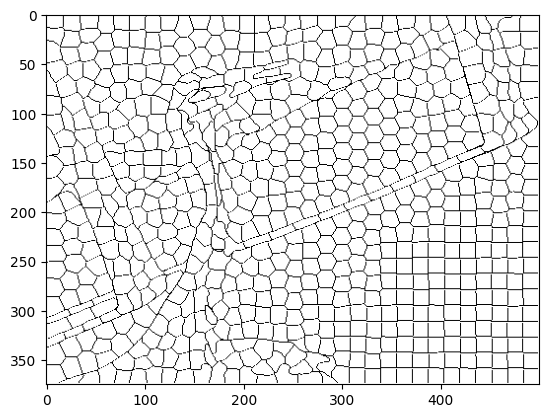

In [13]:
plt.imshow(~chosen_superpixels_mask, cmap="gray")

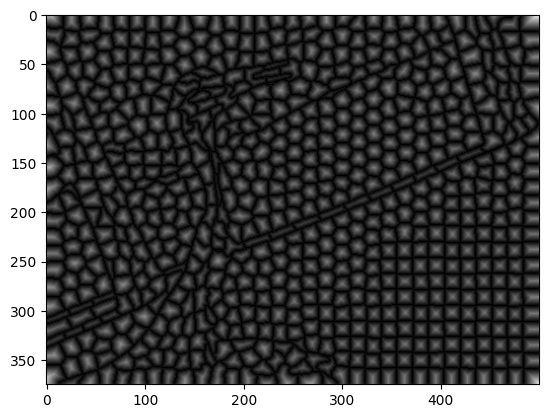

In [14]:
dist_trans = cv2.distanceTransform(~chosen_superpixels_mask, cv2.DIST_L2, 5)
plt.imshow(dist_trans, cmap="gray")

In [15]:
dist_trans.shape

(375, 500)

In [39]:
local_maxima = np.zeros(chosen_superpixels_mask.shape, np.uint8)
local_maxima_coord = []

for mask in masks:
    masked = mask * dist_trans
    local_maximum = np.argwhere(masked == np.max(masked))[0]
    local_maxima[local_maximum[0], local_maximum[1]] = 1
    
    local_maxima_coord.append(np.array([local_maximum[1], (local_maxima.shape[0]-1)-local_maximum[0]]))

local_maxima_coord = np.array(local_maxima_coord)
print(local_maxima_coord.shape)
print(local_maxima_coord)

(713, 2)
[[  0 374]
 [ 10 353]
 [  0 336]
 ...
 [499  39]
 [499  23]
 [499   0]]


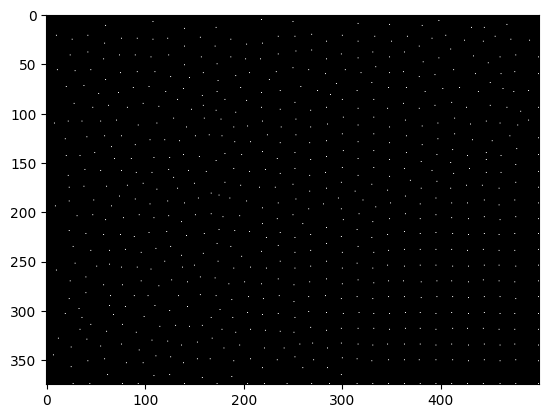

In [40]:
plt.imshow(local_maxima, cmap="gray")

In [41]:
from scipy.spatial import Delaunay
import networkx as nx
from networkx.algorithms.shortest_paths.weighted import dijkstra_path

trangulation = Delaunay(local_maxima_coord)
len(trangulation.simplices)

1348

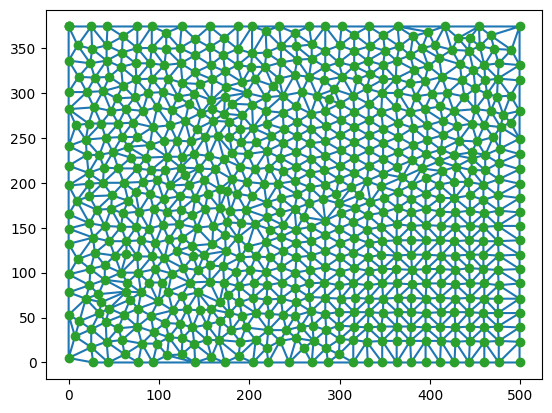

In [42]:
plt.triplot(local_maxima_coord[:,0], local_maxima_coord[:,1], trangulation.simplices)
plt.plot(local_maxima_coord[:,0], local_maxima_coord[:,1], 'o')
plt.show()

In [45]:
G = nx.Graph()
for path in trangulation.simplices:
    nx.add_path(G, path)

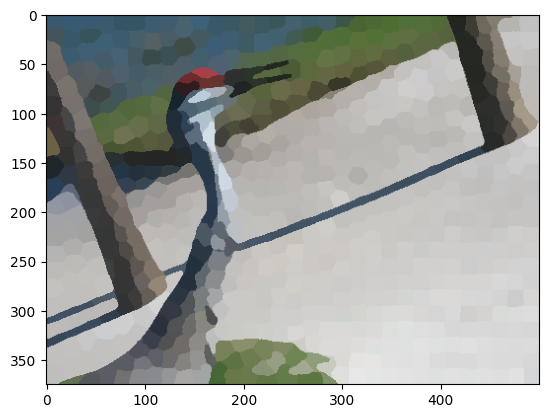

In [18]:
lab_2_bgr = cv2.cvtColor(mean_img, cv2.COLOR_Lab2BGR)
plt.imshow(lab_2_bgr[:,:,::-1])

## Semi-supervised mask creation

In [19]:
# click on superpixels

# idea: priemerna hodnota kazdeho superpixelu -> "kachlickovy" obrazok -> potom floodfill
# potom grabcut

# alebo naklikanie hranicnych superpixelov - tie budu possible foreground a vnutri budu sure foreground

In [20]:
clicks = []

def mouse_callback(event, x, y, flags, param):
    if event == cv2.EVENT_LBUTTONDOWN:
        x_math = x
        y_math = local_maxima.shape[0]-y
        print(f"Left button clicked at ({x_math}, {y_math})")
        clicks.append(np.array([x_math, y_math]))

In [161]:
clicks = []

cv2.imshow("Image", lab_2_bgr)
cv2.setMouseCallback('Image', mouse_callback)
cv2.waitKey(0)
cv2.destroyAllWindows()

Left button clicked at (23, 1)
Left button clicked at (134, 125)
Left button clicked at (114, 277)
Left button clicked at (173, 333)
Left button clicked at (257, 329)
Left button clicked at (261, 290)
Left button clicked at (185, 254)
Left button clicked at (220, 156)
Left button clicked at (192, 7)


In [162]:
distances = []
nearest_to_clicks = []

for i, point_click in enumerate(clicks):
    for j, point_maximum in enumerate(local_maxima_coord):
        distances.append(np.array([
            i, j, cv2.norm(point_maximum, point_click)
        ]))

distances = np.array(distances)

for i in range(len(clicks)):
    interest_points = distances[distances[:,0] == i]
    minimum_dist = interest_points[interest_points[:,2] == np.min(interest_points[:,2]), 1]
    nearest_to_clicks.append(int(minimum_dist[0]))

indices_of_nearest = []

for coord_click in  local_maxima_coord[nearest_to_clicks]:
    for i, coord in enumerate(local_maxima_coord):
        if (coord == coord_click).all():
            indices_of_nearest.append(i)
            break

indices_of_nearest = np.array(indices_of_nearest)

In [163]:
result = copy.deepcopy(local_maxima_coord[nearest_to_clicks])

for i in range(len(indices_of_nearest)-1):
    path = dijkstra_path(G, indices_of_nearest[i], indices_of_nearest[i+1])
    result = np.append(result, values=local_maxima_coord[path], axis=0)

path = dijkstra_path(G, indices_of_nearest[0], indices_of_nearest[-1])
result = np.append(result, values=local_maxima_coord[path], axis=0)

In [164]:
selected_local_maxima = np.zeros(chosen_superpixels_mask.shape, np.uint8)

for local_max in local_maxima_coord[nearest_to_clicks]:
    selected_local_maxima[(local_maxima.shape[0]-1)-local_max[1], local_max[0]] = 1

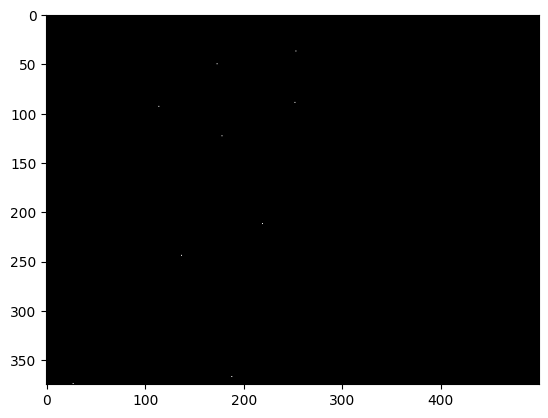

In [165]:
plt.imshow(selected_local_maxima, cmap="gray")

In [166]:
found_local_maxima = np.zeros(chosen_superpixels_mask.shape, np.uint8)

for local_max in result:
    found_local_maxima[(local_maxima.shape[0]-1)-local_max[1], local_max[0]] = 1

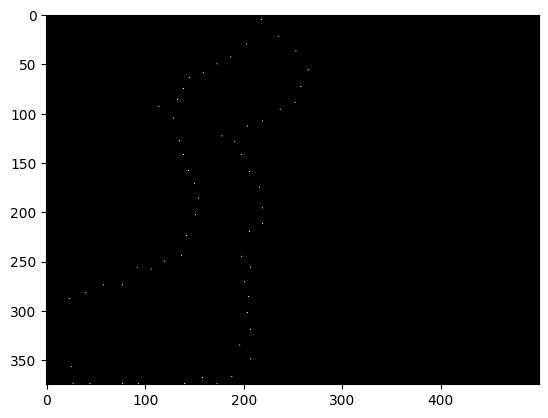

In [167]:
plt.imshow(found_local_maxima, cmap="gray")

Draw masks at local maxima:

In [168]:
selected_superpixels = np.zeros(local_maxima.shape, np.uint8)

for mask in masks:
    for local_max in result:
        if mask[(local_maxima.shape[0]-1)-local_max[1], local_max[0]] == 1:
            selected_superpixels |= mask

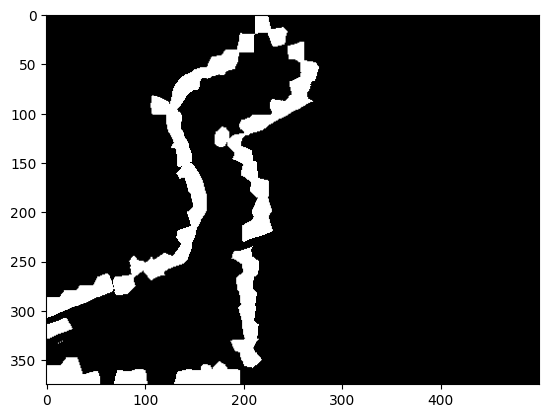

In [169]:
plt.imshow(selected_superpixels, cmap="gray")

In [184]:
struct_elem = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11,11))
dilated_selection = cv2.dilate(selected_superpixels, struct_elem, iterations=4)

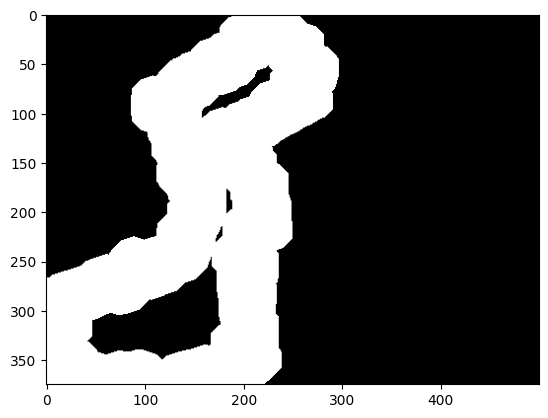

In [185]:
plt.imshow(dilated_selection, cmap="gray")

In [191]:
contours, _ = cv2.findContours(dilated_selection, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
mask = np.zeros(dilated_selection.shape, dtype=np.uint8)
mask = cv2.fillPoly(mask, contours, 1)

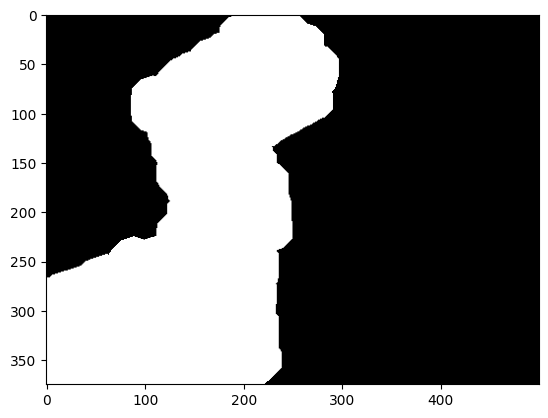

In [192]:
plt.imshow(mask, cmap="gray")

In [206]:
dilated_selection[dilated_selection == 1] = cv2.GC_PR_FGD

certain_fg = np.logical_xor(mask, dilated_selection)
certain_fg[certain_fg == 1] = cv2.GC_FGD

grabcut_mask = dilated_selection + certain_fg

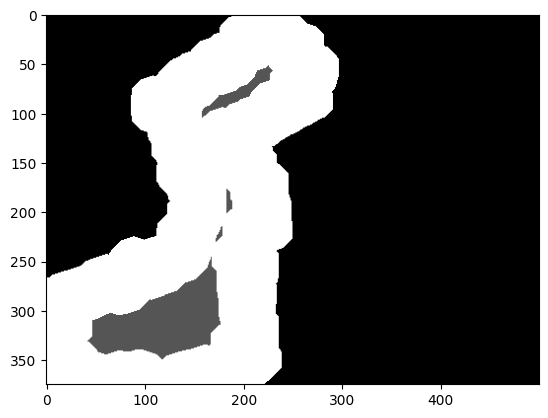

In [207]:
plt.imshow(grabcut_mask, cmap="gray")

In [208]:
bgd_model = np.zeros((1,65),np.float64)
fgd_model = np.zeros((1,65),np.float64)
grabcut_mask, bgd_model, fgd_model = cv2.grabCut(images[0], grabcut_mask, None, bgd_model, fgd_model, 5, cv2.GC_INIT_WITH_MASK)

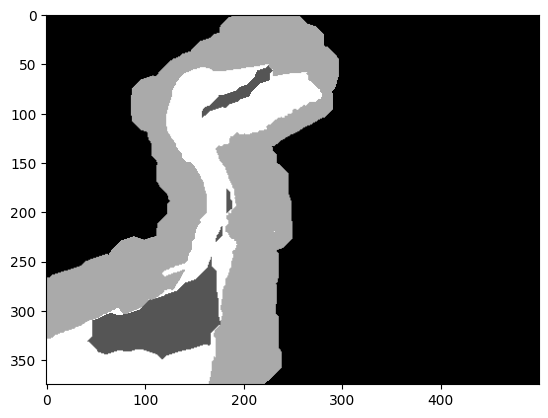

In [209]:
plt.imshow(grabcut_mask, cmap="gray")

In [210]:
grabcut_mask = np.where((grabcut_mask == cv2.GC_FGD) | (grabcut_mask == cv2.GC_PR_FGD), 1, 0)

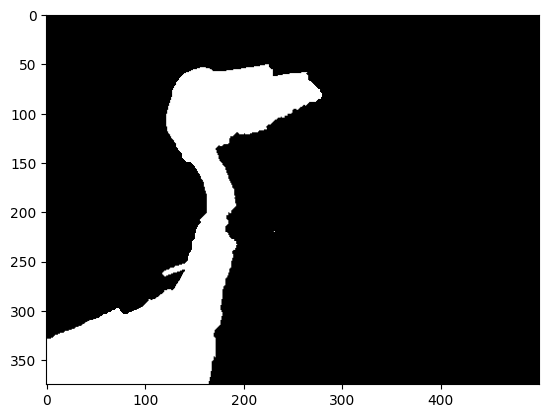

In [211]:
plt.imshow(grabcut_mask, cmap="gray")

In [212]:
segmented = images[0] * cv2.merge([grabcut_mask,grabcut_mask,grabcut_mask])

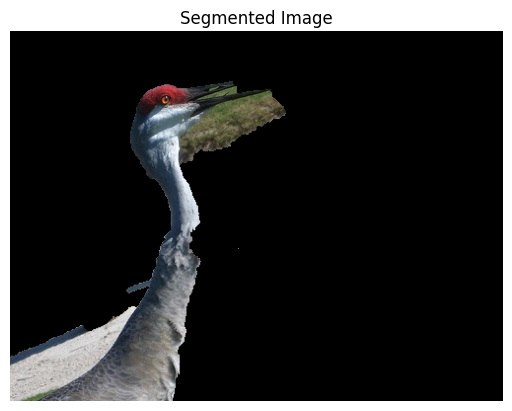

In [213]:
plt.axis("off")
plt.title("Segmented Image")
plt.imshow(segmented[:,:,::-1])